# 1. Import libraries and read datasets

In [1]:
#### Import libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [2]:
#### Read datasets and subset to columns of interest
df_reddit = pd.read_csv("reddit.csv")
df_gab = pd.read_csv("gab.csv")

df_reddit = df_reddit[['text', 'hate_speech_idx']]
df_gab = df_gab[['text', 'hate_speech_idx']]

# 2. Get a sense of how each of the two datasets looks like

### Reddit data

In [3]:
df_reddit.shape

(5020, 2)

In [4]:
df_reddit.head()

,text,hate_speech_idx
0,1. A subsection of retarded Hungarians? Ohh bo...,[1]
1,"1. > ""y'all hear sumn?"" by all means I live i...",[3]
2,1. wouldn't the defenders or whatever they are...,NaN
3,1. Because the Japanese aren't retarded and kn...,[1]
4,1. That might be true if we didn't have an exa...,"[2, 3]"


In [5]:
# Content of a row in 'text' column 
df_reddit.iloc[5,0]

"1. Why, what is the point of making all of that fuss over a egg McMuffin it’s probably not even real egg.\n2. \tit is actually, i worked there a long time ago. the aren't even the crappy boxed liquid egg \n3. \t\t[deleted]\n4. \t\t\tThen you're ignorant.   I worked as a grill guy at McDonald's for 2 years. I cracked thousands of eggs into holders and tipped them  into O shaped egg rings on the grill.  It's real eggs. Unless there is a fake egg that looks tastes smells and breaks exactly like a real egg. \n5. \t\t\t\tI don't believe you. No way McDonald's could sell eggs, *eggs*, at that price. Only the highest end restaurants would sell such a luxury food. Chicken eggs are a delicacy and I won't let you fill me with lies. \n6. \t\t\t\t\tCould be a loss leader. Also, you probably get eggs pretty cheap when you buy as many as McDonald's does. \n7. \t\t\t\t\t\tHe was joking.\n8. \t\t\t\t\t\t\tjesus, this is the most retarded thread i've read in a while.\n9. \t\t\t\t\t\t\t\tOh no you didn

### Gab data

In [6]:
df_gab.shape

(11825, 2)

In [7]:
df_gab.head()

,text,hate_speech_idx
0,1. i joined gab to remind myself how retarded ...,[1]
1,1. This is what the left is really scared of. ...,[3]
2,1. It makes you an asshole.\n2. \tGive it to a...,[2]
3,1. So they manage to provide a whole lot of da...,[2]
4,"1. Hi there, i,m Keith, i hope you are doing w...",[3]


In [8]:
# Content of a row in 'text' column
df_gab.iloc[5,0]

'1. you sound like a faggot \n'

# 3. Data Manipulation - Get it in format such that each row is at individual comment level having label whether it is hate speech or not 

### Reddit data

In [9]:
## Get dataset such that each row corresponds to a comment (currently it is at conversation level)
reddit = df_reddit.drop('text', axis=1).join(df_reddit.text.str.split(pat="\n", expand=True).stack().reset_index(drop=True, level=1).rename('text'))
reddit.head(6)

,hate_speech_idx,text
0,[1],1. A subsection of retarded Hungarians? Ohh bo...
0,[1],2. \tHiii. Just got off work. 444 is mainly th...
0,[1],3. \t\twow i guess soyboys are the same in eve...
0,[1],4. \t\t\tOwen Benjamin's soyboy song goes for ...
0,[1],
1,[3],"1. > ""y'all hear sumn?"" by all means I live i..."


In [10]:
## Clean 'text' column and reset index of data frame
reddit = reddit[reddit['text'] != ""]
reddit['text'] = reddit['text'].str.replace(pat=r'[\t]', repl='', regex=True)
reddit = reddit.reset_index(drop=True)
reddit.head()

,hate_speech_idx,text
0,[1],1. A subsection of retarded Hungarians? Ohh bo...
1,[1],2. Hiii. Just got off work. 444 is mainly the ...
2,[1],3. wow i guess soyboys are the same in every c...
3,[1],4. Owen Benjamin's soyboy song goes for every ...
4,[3],"1. > ""y'all hear sumn?"" by all means I live i..."


In [11]:
## Create 'comment_idx' column capturing comment number mentioned in 'text' column. Clean 'text' & 'hate_speech_idx' columns
reddit['comment_idx'] = reddit['text'].astype(str).str[0]
reddit['text'] = reddit['text'].str[2:]
reddit['hate_speech_idx'] = reddit['hate_speech_idx'].str.replace(pat=r'[\[\]]', repl='', regex=True)
reddit.head()

,hate_speech_idx,text,comment_idx
0,1,A subsection of retarded Hungarians? Ohh boy....,1
1,1,Hiii. Just got off work. 444 is mainly the ty...,2
2,1,wow i guess soyboys are the same in every cou...,3
3,1,Owen Benjamin's soyboy song goes for every co...,4
4,3,"> ""y'all hear sumn?"" by all means I live in ...",1


In [12]:
## Create 'hate_speech' column labeling whether hate speech or not, by comparing 'comment_idx' and 'hate_speech_idx' columns
reddit['hate_speech'] = [(reddit['comment_idx'][i]) in (reddit['hate_speech_idx'][i]) if pd.notnull(reddit['hate_speech_idx'][i]) else False for i in range(len(reddit.index))]
reddit['hate_speech'] = reddit['hate_speech'].astype(int)
reddit.head(10)

,hate_speech_idx,text,comment_idx,hate_speech
0,1,A subsection of retarded Hungarians? Ohh boy....,1,1
1,1,Hiii. Just got off work. 444 is mainly the ty...,2,0
2,1,wow i guess soyboys are the same in every cou...,3,0
3,1,Owen Benjamin's soyboy song goes for every co...,4,0
4,3,"> ""y'all hear sumn?"" by all means I live in ...",1,0
5,3,[removed],2,0
6,3,ah a liberal has slipped in. you can tell bec...,3,1
7,NaN,wouldn't the defenders or whatever they are a...,1,0
8,NaN,'inclusive' = not white,2,0
9,NaN,“Harvard is working to be more inclusive.” “...,3,0


In [13]:
## Subset to columns of interest 
reddit = reddit[['text', 'hate_speech']]
reddit.head(10)

,text,hate_speech
0,A subsection of retarded Hungarians? Ohh boy....,1
1,Hiii. Just got off work. 444 is mainly the ty...,0
2,wow i guess soyboys are the same in every cou...,0
3,Owen Benjamin's soyboy song goes for every co...,0
4,"> ""y'all hear sumn?"" by all means I live in ...",0
5,[removed],0
6,ah a liberal has slipped in. you can tell bec...,1
7,wouldn't the defenders or whatever they are a...,0
8,'inclusive' = not white,0
9,“Harvard is working to be more inclusive.” “...,0


In [14]:
## Check if any Nulls
reddit.isnull().sum()

text           0
hate_speech    0
dtype: int64

In [15]:
## Check dataset shape
reddit.shape

(22323, 2)

### Gab data

In [16]:
## Get dataset such that each row corresponds to a comment (currently it is at conversation level)
gab = df_gab.drop('text', axis=1).join(df_gab.text.str.split(pat="\n", expand=True).stack().reset_index(drop=True, level=1).rename('text'))
gab.head(6)

,hate_speech_idx,text
0,[1],1. i joined gab to remind myself how retarded ...
0,[1],
1,[3],1. This is what the left is really scared of. ...
1,[3],2. \tThat literally looks like a monkey. Why a...
1,[3],3. \t\tDumb Cunt
1,[3],


In [17]:
## Clean 'text' column and reset index of data frame
gab = gab[gab['text'] != ""]
gab['text'] = gab['text'].str.replace(pat=r'[\t]', repl='', regex=True)
gab = gab.reset_index(drop=True)
gab.head()

,hate_speech_idx,text
0,[1],1. i joined gab to remind myself how retarded ...
1,[3],1. This is what the left is really scared of. ...
2,[3],2. That literally looks like a monkey. Why are...
3,[3],3. Dumb Cunt
4,[2],1. It makes you an asshole.


In [18]:
## Create 'comment_idx' column capturing comment number mentioned in 'text' column. Clean 'text' & 'hate_speech_idx' columns
gab['comment_idx'] = gab['text'].astype(str).str[0]
gab['text'] = gab['text'].str[2:]
gab['hate_speech_idx'] = gab['hate_speech_idx'].str.replace(pat=r'[\[\]]', repl='', regex=True)
gab.head()

,hate_speech_idx,text,comment_idx
0,1,i joined gab to remind myself how retarded je...,1
1,3,This is what the left is really scared of. ...,1
2,3,That literally looks like a monkey. Why are w...,2
3,3,Dumb Cunt,3
4,2,It makes you an asshole.,1


In [19]:
## Create 'hate_speech' column labeling whether hate speech or not, by comparing 'comment_idx' and 'hate_speech_idx' columns
gab['hate_speech'] = [(gab['comment_idx'][i]) in (gab['hate_speech_idx'][i]) if pd.notnull(gab['hate_speech_idx'][i]) else False for i in range(len(gab.index))]
gab['hate_speech'] = gab['hate_speech'].astype(int)
gab.head(10)

,hate_speech_idx,text,comment_idx,hate_speech
0,1,i joined gab to remind myself how retarded je...,1,1
1,3,This is what the left is really scared of. ...,1,0
2,3,That literally looks like a monkey. Why are w...,2,0
3,3,Dumb Cunt,3,1
4,2,It makes you an asshole.,1,0
5,2,"Give it to a soldier who has defend it , the...",2,1
6,2,So they manage to provide a whole lot of data...,1,0
7,2,yup. i cant smoke in a bar because it's harmf...,2,1
8,3,"Hi there, i,m Keith, i hope you are doing wel...",1,0
9,3,Fuck off,2,0


In [20]:
## Subset to columns of interest 
gab = gab[['text', 'hate_speech']]
gab.head(10)

,text,hate_speech
0,i joined gab to remind myself how retarded je...,1
1,This is what the left is really scared of. ...,0
2,That literally looks like a monkey. Why are w...,0
3,Dumb Cunt,1
4,It makes you an asshole.,0
5,"Give it to a soldier who has defend it , the...",1
6,So they manage to provide a whole lot of data...,0
7,yup. i cant smoke in a bar because it's harmf...,1
8,"Hi there, i,m Keith, i hope you are doing wel...",0
9,Fuck off,0


In [21]:
## Check if any Nulls
gab.isnull().sum()

text           0
hate_speech    0
dtype: int64

In [22]:
gab.shape

(33776, 2)

# 4. Data Cleaning of 'text' column

### Reddit data

In [23]:
## Convert to lower case
reddit['text']=reddit['text'].apply(lambda x: x.lower())
reddit['text'][6]

' ah a liberal has slipped in. you can tell because the first question asked was loaded and retarded.  >  what does "working hard" mean? your political views get more validated by how much manual labour you put in?   where did i say that? and yes, of course you have no clue what "working hard" means. few soyboys do.  > based on your comment regarding the ec i guess you don\'t really think that 2 mil majority of people who voted for hillary don\'t really matter.  i shouldn\'t have to explain to you the point of the ec. if you want to talk to someone who is more patient with you than i am, you can check out askthe_donald. '

In [24]:
## Remove digits and words containing digits
reddit['text']=reddit['text'].apply(lambda x: re.sub('\w*\d\w*','', x))
reddit['text'][6]

' ah a liberal has slipped in. you can tell because the first question asked was loaded and retarded.  >  what does "working hard" mean? your political views get more validated by how much manual labour you put in?   where did i say that? and yes, of course you have no clue what "working hard" means. few soyboys do.  > based on your comment regarding the ec i guess you don\'t really think that  mil majority of people who voted for hillary don\'t really matter.  i shouldn\'t have to explain to you the point of the ec. if you want to talk to someone who is more patient with you than i am, you can check out askthe_donald. '

In [25]:
## Remove punctuations
reddit['text']=reddit['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
reddit['text'][6]

' ah a liberal has slipped in you can tell because the first question asked was loaded and retarded    what does working hard mean your political views get more validated by how much manual labour you put in   where did i say that and yes of course you have no clue what working hard means few soyboys do   based on your comment regarding the ec i guess you dont really think that  mil majority of people who voted for hillary dont really matter  i shouldnt have to explain to you the point of the ec if you want to talk to someone who is more patient with you than i am you can check out askthedonald '

In [26]:
# Remove extra spaces
reddit['text']=reddit['text'].apply(lambda x: re.sub(' +',' ',x))
reddit['text'][6]

' ah a liberal has slipped in you can tell because the first question asked was loaded and retarded what does working hard mean your political views get more validated by how much manual labour you put in where did i say that and yes of course you have no clue what working hard means few soyboys do based on your comment regarding the ec i guess you dont really think that mil majority of people who voted for hillary dont really matter i shouldnt have to explain to you the point of the ec if you want to talk to someone who is more patient with you than i am you can check out askthedonald '

### Gab data

In [27]:
## Convert to lower case
gab['text']=gab['text'].apply(lambda x: x.lower())
gab['text'][5]

' give it to a  soldier who has defend it , then try to burn it . show me what a badass you really are.  the flag is helpless to stop you or fight back . completely unnecessary act , its proves nothing and accomplishes nothing. it only shows your a ignorant weak faggot  . like kicking a puppy ,,,  it shows how weak and worthless you are '

In [28]:
## Remove digits and words containing digits
gab['text']=gab['text'].apply(lambda x: re.sub('\w*\d\w*','', x))
gab['text'][5]

' give it to a  soldier who has defend it , then try to burn it . show me what a badass you really are.  the flag is helpless to stop you or fight back . completely unnecessary act , its proves nothing and accomplishes nothing. it only shows your a ignorant weak faggot  . like kicking a puppy ,,,  it shows how weak and worthless you are '

In [29]:
## Remove punctuations
gab['text']=gab['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
gab['text'][5]

' give it to a  soldier who has defend it  then try to burn it  show me what a badass you really are  the flag is helpless to stop you or fight back  completely unnecessary act  its proves nothing and accomplishes nothing it only shows your a ignorant weak faggot   like kicking a puppy   it shows how weak and worthless you are '

In [30]:
# Remove extra spaces
gab['text']=gab['text'].apply(lambda x: re.sub(' +',' ',x))
gab['text'][5]

' give it to a soldier who has defend it then try to burn it show me what a badass you really are the flag is helpless to stop you or fight back completely unnecessary act its proves nothing and accomplishes nothing it only shows your a ignorant weak faggot like kicking a puppy it shows how weak and worthless you are '

# 5. Exploratory Data Analysis

## 5.a Distribution of the labels in 'hate_speech' column

### Reddit data

In [31]:
label_dstn = reddit.groupby('hate_speech')['hate_speech'].count().reset_index(name='Number of occurences')

In [32]:
label_dstn

,hate_speech,Number of occurences
0,0,15213
1,1,7110


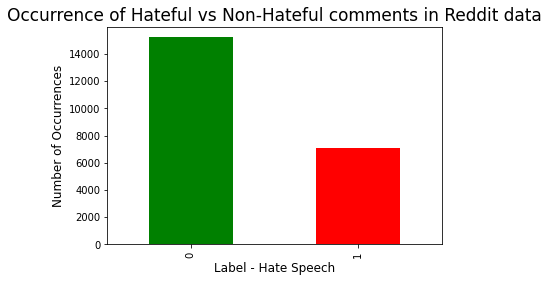

In [33]:
label_dstn.plot.bar(x='hate_speech', y='Number of occurences', color= ('green', 'red'), legend=False)
plt.xlabel('Label - Hate Speech', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title("Occurrence of Hateful vs Non-Hateful comments in Reddit data", fontsize = 17)
plt.show()

### Gab data

In [34]:
label_dstn = gab.groupby('hate_speech')['hate_speech'].count().reset_index(name='Number of occurences')

In [35]:
label_dstn

,hate_speech,Number of occurences
0,0,17412
1,1,16364


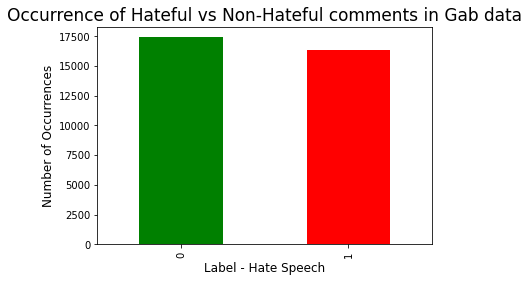

In [36]:
label_dstn.plot.bar(x='hate_speech', y='Number of occurences', color= ('green', 'red'), legend=False)
plt.xlabel('Label - Hate Speech', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.title("Occurrence of Hateful vs Non-Hateful comments in Gab data", fontsize = 17)
plt.show()

## 5.b Frequent words for each label in 'hate_speech' column

In [37]:
## Function to get wordcloud

stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None, color='white'):
    wordcloud = WordCloud(
        background_color=color,
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=1.4)

    plt.imshow(wordcloud)
    plt.show()

### Reddit data

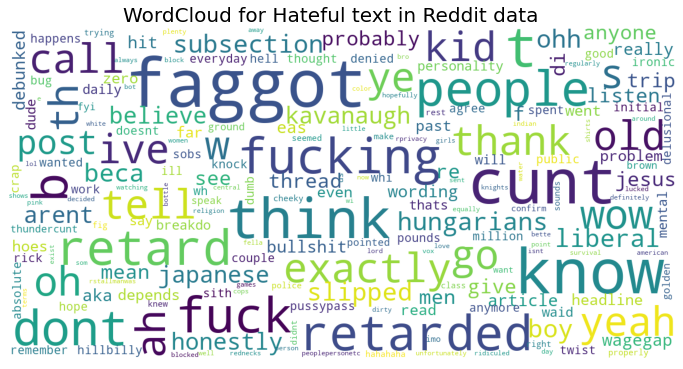

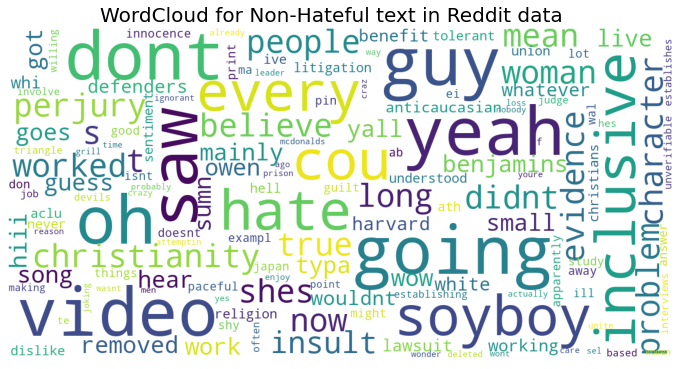

In [38]:
reddit_hate = reddit.loc[reddit['hate_speech'] == 1]
reddit_nonhate = reddit.loc[reddit['hate_speech'] == 0]
show_wordcloud(reddit_hate["text"], "WordCloud for Hateful text in Reddit data")
show_wordcloud(reddit_nonhate["text"], "WordCloud for Non-Hateful text in Reddit data")

### Gab data

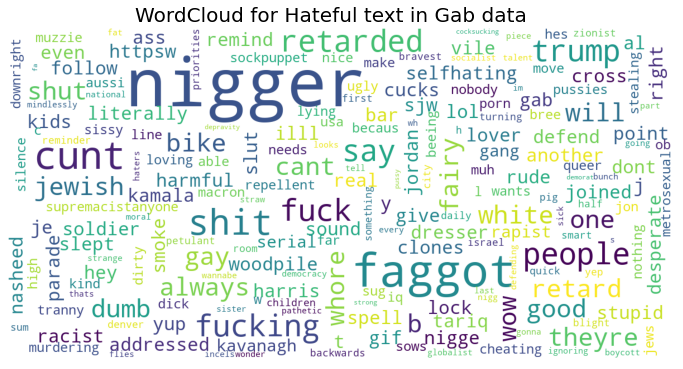

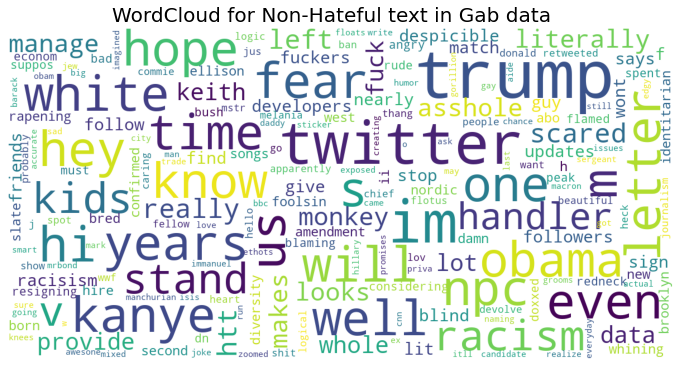

In [39]:
gab_hate = gab.loc[gab['hate_speech'] == 1]
gab_nonhate = gab.loc[gab['hate_speech'] == 0]
show_wordcloud(gab_hate["text"], "WordCloud for Hateful text in Gab data")
show_wordcloud(gab_nonhate["text"], "WordCloud for Non-Hateful text in Gab data")